In [128]:
import sys
sys.path.append("../")

import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

In [129]:
import pandas as pd

In [154]:
pair='BTCUSDT'
granularity = '1h'

df = pd.read_pickle(f"crypto/{pair}_{granularity}.pkl")

In [155]:
pd.set_option('display.max_rows', None)

In [156]:
df.head()

Time     Open     High      Low    Close      Volume
0 2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02  511.814901
1 2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27  883.052603
2 2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85  655.156809
3 2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01  783.724867
4 2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27  467.812578

In [157]:
df['time'] = df['Time']

In [158]:
import pandas as pd

def calculate_pivot_points(df, period=2):
    """
    Calcula os níveis de suporte e resistência baseados em Pivot Points, de forma vetorizada.
    
    Args:
        df (pd.DataFrame): DataFrame contendo as colunas 'High', 'Low', 'Close'.
        period (int): Período para calcular os pivots.

    Returns:
        pd.DataFrame: DataFrame atualizado com colunas Pivot, Resistance1, Resistance2, Support1, Support2.
    """
    rolling_high = df['High'].rolling(window=period, min_periods=1).max()
    rolling_low = df['Low'].rolling(window=period, min_periods=1).min()
    rolling_close = df['Close'].rolling(window=period, min_periods=1).mean()

    df['Pivot'] = (rolling_high + rolling_low + rolling_close) / 3
    df['Resistance1'] = (2 * df['Pivot']) - rolling_low
    df['Support1'] = (2 * df['Pivot']) - rolling_high
    df['Resistance2'] = df['Pivot'] + (rolling_high - rolling_low)
    df['Support2'] = df['Pivot'] - (rolling_high - rolling_low)
    
    return df



In [159]:
import pandas as pd
import ta  # Biblioteca de indicadores técnicos

def supertrend(df, atr_multiplier=3, atr_period=15):
    """
    Calcula o indicador SuperTrend ajustado.

    Args:
        df (pd.DataFrame): DataFrame contendo 'High', 'Low', e 'Close'.
        atr_multiplier (float): Multiplicador para o cálculo das bandas.
        atr_period (int): Período para o cálculo do ATR.

    Returns:
        pd.DataFrame: DataFrame com colunas adicionais para SuperTrend, upperband e lowerband.
    """
    # Cálculo do ATR
    df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=atr_period)

    # Cálculo das bandas básicas
    avg_high_low = (df['High'] + df['Low']) / 2
    df['BasicUpperband'] = avg_high_low + (atr_multiplier * df['ATR'])
    df['BasicLowerband'] = avg_high_low - (atr_multiplier * df['ATR'])

    # Inicializar listas para bandas superiores e inferiores ajustadas
    upper_band = [df['BasicUpperband'].iloc[0]]
    lower_band = [df['BasicLowerband'].iloc[0]]

    # Ajustar bandas com base nas condições de cruzamento
    for i in range(1, len(df)):
        # Ajuste da banda superior
        if (df['BasicUpperband'].iloc[i] < upper_band[i - 1]) or (df['Close'].iloc[i - 1] > upper_band[i - 1]):
            upper_band.append(df['BasicUpperband'].iloc[i])
        else:
            upper_band.append(upper_band[i - 1])

        # Ajuste da banda inferior
        if (df['BasicLowerband'].iloc[i] > lower_band[i - 1]) or (df['Close'].iloc[i - 1] < lower_band[i - 1]):
            lower_band.append(df['BasicLowerband'].iloc[i])
        else:
            lower_band.append(lower_band[i - 1])

    # Adicionar bandas ajustadas ao DataFrame
    df['Upperband'] = upper_band
    df['Lowerband'] = lower_band

    # Determinar a tendência e o SuperTrend
    trend = [1]  # Inicializando tendência: 1 = Alta, -1 = Baixa
    supertrend = [df['Upperband'].iloc[0]]  # Inicializando SuperTrend

    for i in range(1, len(df)):
        # Atualizar tendência
        if trend[i - 1] == 1 and df['Close'].iloc[i] < df['Lowerband'].iloc[i]:
            trend.append(-1)
        elif trend[i - 1] == -1 and df['Close'].iloc[i] > df['Upperband'].iloc[i]:
            trend.append(1)
        else:
            trend.append(trend[i - 1])

        # Atualizar SuperTrend
        if trend[i] == -1:
            supertrend.append(df['Upperband'].iloc[i])
        else:
            supertrend.append(df['Lowerband'].iloc[i])

    df['Trend'] = trend
    df['SuperTrend'] = supertrend

    # Remover colunas temporárias
    df.drop(['BasicUpperband', 'BasicLowerband'], axis=1, inplace=True)

    return df


In [160]:
df.head()

Time     Open     High      Low    Close      Volume  \
0 2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02  511.814901   
1 2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27  883.052603   
2 2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85  655.156809   
3 2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01  783.724867   
4 2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27  467.812578   

                 time  
0 2020-01-01 00:00:00  
1 2020-01-01 01:00:00  
2 2020-01-01 02:00:00  
3 2020-01-01 03:00:00  
4 2020-01-01 04:00:00

In [167]:
# Calculando Pivot Points
df_with_pivot = calculate_pivot_points(df, period=2)

# Calculando SuperTrend
df_with_supertrend = supertrend(df_with_pivot, atr_multiplier=3, atr_period=10)


In [168]:
df_with_supertrend.head()

Time     Open     High      Low    Close      Volume  \
0 2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02  511.814901   
1 2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27  883.052603   
2 2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85  655.156809   
3 2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01  783.724867   
4 2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27  467.812578   

                 time        Pivot  Resistance1     Support1  Resistance2  \
0 2020-01-01 00:00:00  7182.910000  7190.360000  7169.570000  7203.700000   
1 2020-01-01 01:00:00  7200.701667  7225.943333  7171.403333  7255.241667   
2 2020-01-01 02:00:00  7216.713333  7257.716667  7188.556667  7285.873333   
3 2020-01-01 03:00:00  7230.113333  7248.816667  7215.226667  7263.703333   
4 2020-01-01 04:00:00  7227.056667  7239.083333  7209.113333  7257.026667   

      Support2  ATR  Upperband  Lowerband  Trend  SuperTrend  
0  7162.120000  0.0   7185.855   7185.855      1    7185.855  
1  7146.161667  0.0   7185.855   7202.855      1    7202.855  
2  7147.553333  0.0   7228.140   7228.140      1    7228.140  
3  7196.523333  0.0   7232.500   7232.500     -1    7232.500  
4  7197.086667  0.0   7222.515   7222.515     -1    7222.515

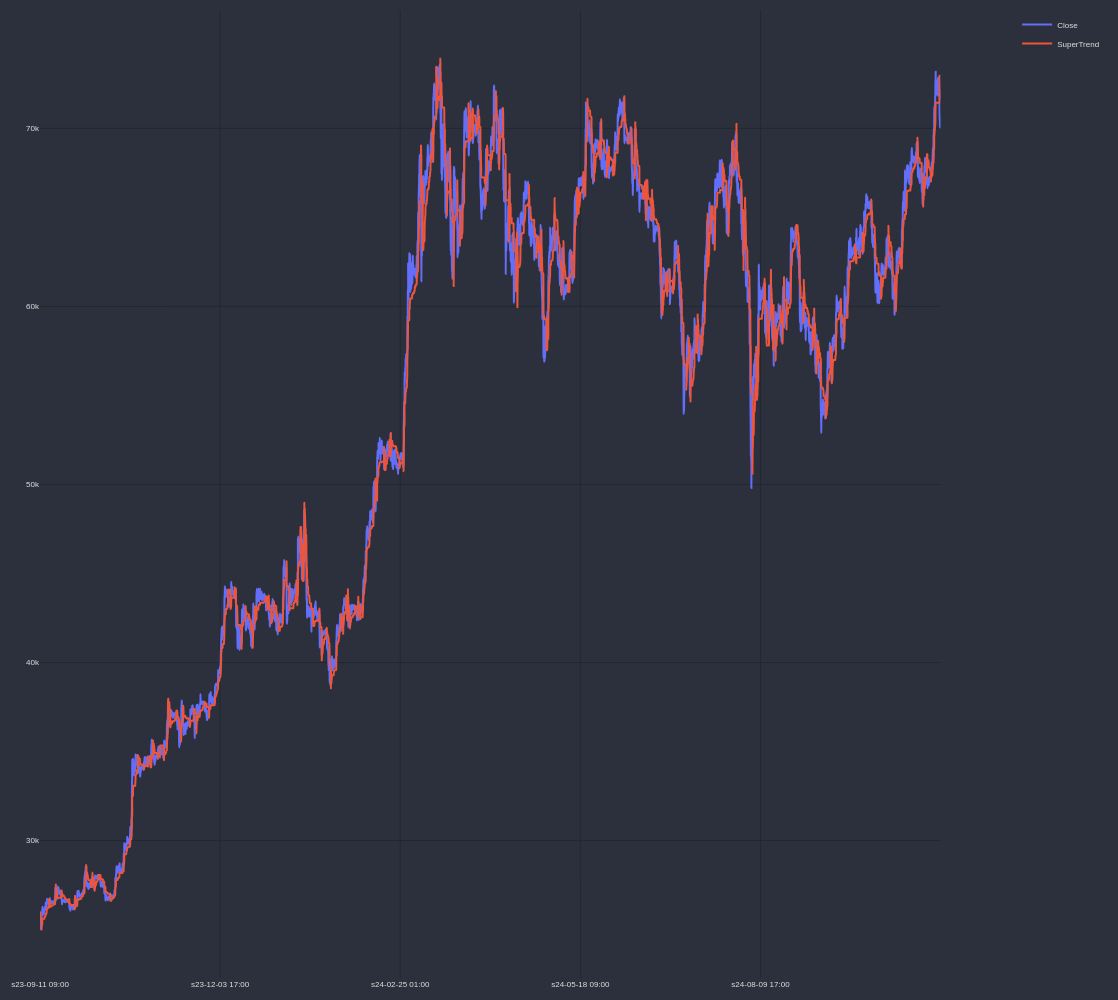

In [169]:
plot_df = df_with_supertrend.iloc[-10000:]

cp = CandlePlot(plot_df, candles=False)
cp.show_plot(line_traces = ['Close','SuperTrend'],
             # sec_traces=['trend'],
             height=1000, width=1100)

In [145]:
pair='BTCUSDT'
granularity = '1m'

df = pd.read_pickle(f"crypto/{pair}_{granularity}.pkl")

In [146]:
def calculate_supertrend(df, atr_multiplier=3, atr_period=15):
    """
    Cálculo básico do SuperTrend para um DataFrame já consolidado.

    Args:
        df (pd.DataFrame): DataFrame contendo 'High', 'Low', e 'Close'.
        atr_multiplier (float): Multiplicador para o cálculo das bandas.
        atr_period (int): Período para o cálculo do ATR.

    Returns:
        pd.DataFrame: DataFrame com colunas adicionais para SuperTrend, Upperband e Lowerband.
    """
    df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=atr_period)

    # Cálculo das bandas básicas
    avg_high_low = (df['High'] + df['Low']) / 2
    df['BasicUpperband'] = avg_high_low + (atr_multiplier * df['ATR'])
    df['BasicLowerband'] = avg_high_low - (atr_multiplier * df['ATR'])

    # Inicializar listas para bandas superiores e inferiores ajustadas
    upper_band = [df['BasicUpperband'].iloc[0]]
    lower_band = [df['BasicLowerband'].iloc[0]]

    # Ajustar bandas com base nas condições de cruzamento
    for i in range(1, len(df)):
        # Ajuste da banda superior
        if (df['BasicUpperband'].iloc[i] < upper_band[i - 1]) or (df['Close'].iloc[i - 1] > upper_band[i - 1]):
            upper_band.append(df['BasicUpperband'].iloc[i])
        else:
            upper_band.append(upper_band[i - 1])

        # Ajuste da banda inferior
        if (df['BasicLowerband'].iloc[i] > lower_band[i - 1]) or (df['Close'].iloc[i - 1] < lower_band[i - 1]):
            lower_band.append(df['BasicLowerband'].iloc[i])
        else:
            lower_band.append(lower_band[i - 1])

    # Adicionar bandas ajustadas ao DataFrame
    df['Upperband'] = upper_band
    df['Lowerband'] = lower_band

    # Determinar a tendência e o SuperTrend
    trend = [1]  # Inicializando tendência: 1 = Alta, -1 = Baixa
    supertrend = [df['Upperband'].iloc[0]]  # Inicializando SuperTrend

    for i in range(1, len(df)):
        # Atualizar tendência
        if trend[i - 1] == 1 and df['Close'].iloc[i] < df['Lowerband'].iloc[i]:
            trend.append(-1)
        elif trend[i - 1] == -1 and df['Close'].iloc[i] > df['Upperband'].iloc[i]:
            trend.append(1)
        else:
            trend.append(trend[i - 1])

        # Atualizar SuperTrend
        if trend[i] == -1:
            supertrend.append(df['Upperband'].iloc[i])
        else:
            supertrend.append(df['Lowerband'].iloc[i])

    df['Trend'] = trend
    df['SuperTrend'] = supertrend

    # Remover colunas temporárias
    df.drop(['BasicUpperband', 'BasicLowerband'], axis=1, inplace=True)

    return df


def supertrend(df, atr_multiplier=3, atr_period=15, new_timeframe=1):
    """
    Método principal para calcular o SuperTrend com suporte a timeframes maiores.

    Args:
        df (pd.DataFrame): DataFrame contendo 'High', 'Low', e 'Close'.
        atr_multiplier (float): Multiplicador para o cálculo das bandas.
        atr_period (int): Período para o cálculo do ATR.
        new_timeframe (int): Número de candles para consolidar (ex: 60 para 1 hora em candles de 1 minuto).

    Returns:
        pd.DataFrame: DataFrame original com colunas adicionais para SuperTrend.
    """
    if new_timeframe > 1:
        # Agrupar os dados
        df_grouped = df.copy()
        df_grouped['group'] = (df_grouped.index // new_timeframe)
        
        grouped = df_grouped.groupby('group').agg({
            'High': 'max',
            'Low': 'min',
            'Close': 'last'
        }).reset_index(drop=True)
        
        # Calcular o SuperTrend no timeframe agrupado
        grouped = calculate_supertrend(grouped, atr_multiplier=atr_multiplier, atr_period=atr_period)
        
        # Interpolar os valores calculados para o dataframe original
        df[f'Upperband_{new_timeframe}'] = grouped['Upperband'].repeat(new_timeframe).iloc[:len(df)].values
        df[f'Lowerband_{new_timeframe}'] = grouped['Lowerband'].repeat(new_timeframe).iloc[:len(df)].values
        df[f'Trend_{new_timeframe}'] = grouped['Trend'].repeat(new_timeframe).iloc[:len(df)].values
        df[f'SuperTrend_{new_timeframe}'] = grouped['SuperTrend'].repeat(new_timeframe).iloc[:len(df)].values
    else:
        # Calcular o SuperTrend no timeframe original
        df = calculate_supertrend(df, atr_multiplier=atr_multiplier, atr_period=atr_period)

    return df


In [151]:
# Calcular o SuperTrend com agrupamento de 60 candles (1 hora em candles de 1 minuto)
df_result = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=180)
df_result = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=60)
df_result = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=30)
df_result = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=15)
df_result = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=5)
df_result['time'] = df_result['Time'].copy()

In [152]:
df_result.head()

Time     Open     High      Low    Close     Volume  \
0 2019-01-01 00:00:00  3701.23  3703.72  3701.09  3702.46  17.100110   
1 2019-01-01 00:01:00  3702.44  3702.63  3695.66  3697.04  23.700604   
2 2019-01-01 00:02:00  3699.42  3702.04  3696.08  3698.14  14.488615   
3 2019-01-01 00:03:00  3697.49  3698.19  3695.97  3696.51   8.499966   
4 2019-01-01 00:04:00  3697.20  3697.62  3695.00  3696.32  21.782886   

   Upperband_180  Lowerband_180  Trend_180  SuperTrend_180  ...  \
0        3694.02        3694.02          1         3694.02  ...   
1        3694.02        3694.02          1         3694.02  ...   
2        3694.02        3694.02          1         3694.02  ...   
3        3694.02        3694.02          1         3694.02  ...   
4        3694.02        3694.02          1         3694.02  ...   

   SuperTrend_30  Upperband_15  Lowerband_15  Trend_15  SuperTrend_15  \
0         3696.8        3696.8        3696.8         1         3696.8   
1         3696.8        3696.8        3696.8         1         3696.8   
2         3696.8        3696.8        3696.8         1         3696.8   
3         3696.8        3696.8        3696.8         1         3696.8   
4         3696.8        3696.8        3696.8         1         3696.8   

   Upperband_5  Lowerband_5  Trend_5  SuperTrend_5                time  
0      3699.36      3699.36        1       3699.36 2019-01-01 00:00:00  
1      3699.36      3699.36        1       3699.36 2019-01-01 00:01:00  
2      3699.36      3699.36        1       3699.36 2019-01-01 00:02:00  
3      3699.36      3699.36        1       3699.36 2019-01-01 00:03:00  
4      3699.36      3699.36        1       3699.36 2019-01-01 00:04:00  

[5 rows x 27 columns]

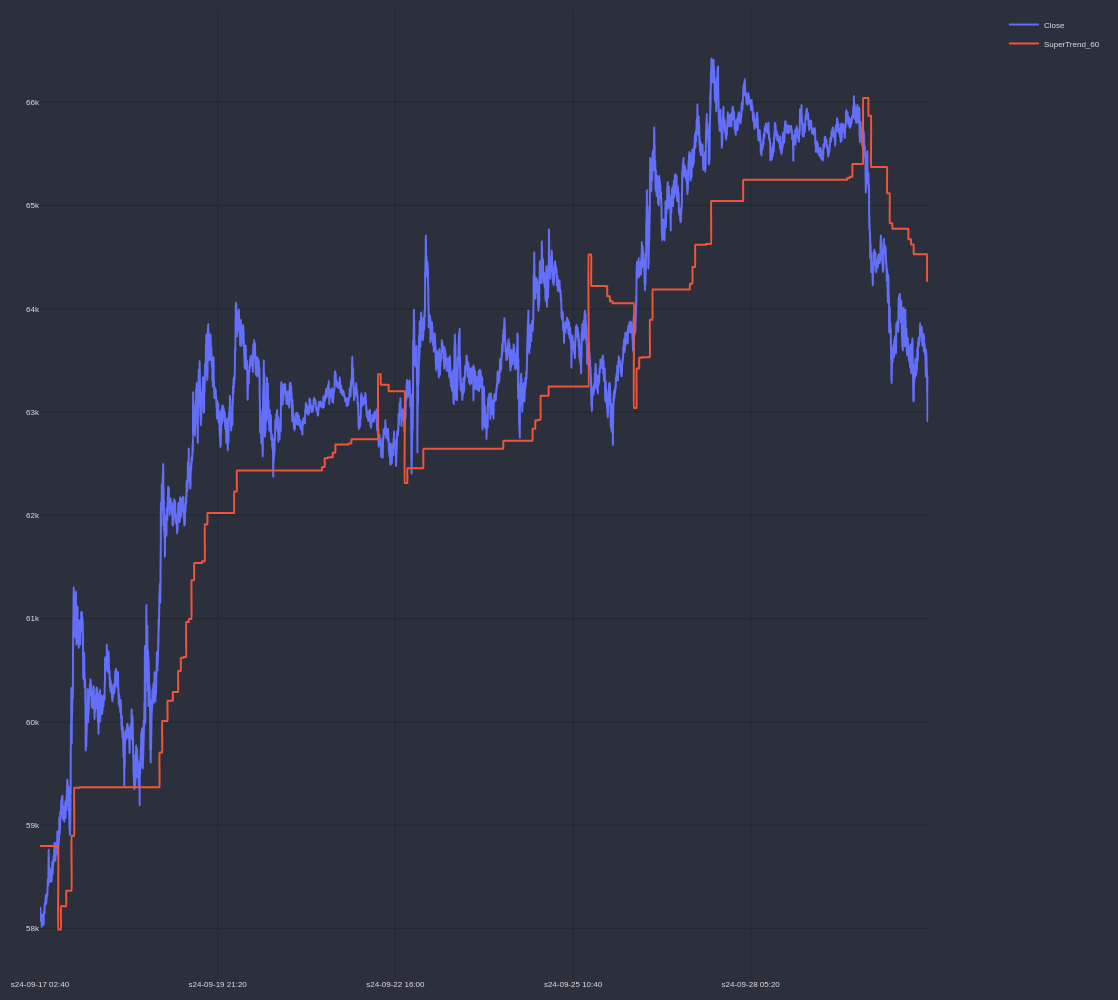

In [153]:
plot_df = df_result.iloc[-20000:]

cp = CandlePlot(plot_df, candles=False)
cp.show_plot(line_traces = ['Close','SuperTrend_60'],
             # sec_traces=['trend'],
             height=1000, width=1100)